In [11]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from skimage import measure
from typing import Tuple, List

In [12]:
# --- Configuration ---
res_dir = 'res'
image_files = []
if os.path.isdir(res_dir): # Verificar si el directorio existe
    # os.listdir() obtiene todos los archivos y carpetas dentro de res_dir
    # Filtramos para quedarnos solo con archivos (no subdirectorios)
    # y opcionalmente, solo con extensiones de imagen comunes
    allowed_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff', '.gif')
    for filename in os.listdir(res_dir):
        file_path = os.path.join(res_dir, filename)
        if os.path.isfile(file_path) and filename.lower().endswith(allowed_extensions):
            image_files.append(filename) # Añadir solo el nombre del archivo a la lista
    print(f"Archivos encontrados en '{res_dir}': {len(image_files)}")
    # print(image_files) # Descomenta si quieres ver la lista completa de archivos
else:
    print(f"Error: El directorio '{res_dir}' no fue encontrado.")
    image_files = [] # Dejar la lista vacía si el directorio no existe


images = {img: cv2.imread(f'res/{img}')for img in image_files}

# --- Display function ---
def display_results(processing_function, images_dict_bgr, **kwargs):
    """
    Displays original and processed images side-by-side.

    Args:
        processing_function: A function that takes a BGR image and returns a BGR image.
        images_dict_bgr: A dictionary {filename: bgr_image}.
        **kwargs: Additional keyword arguments passed to the processing_function.
    """
    num_images = len(images_dict_bgr)
    plt.figure(figsize=(12, num_images * 5)) # Adjust figsize as needed
    plot_index = 1

    print(f"--- Applying method: {processing_function.__name__} ---")

    for filename, img_bgr in images_dict_bgr.items():
        if img_bgr is None:
            print(f"Skipping {filename}: Image data is None.")
            continue


        # 2. Apply the processing function
        processed_bgr = processing_function(img_bgr, **kwargs)

        # 3. Convert processed BGR back to RGB (for matplotlib display)
        processed_rgb = cv2.cvtColor(processed_bgr, cv2.COLOR_BGR2RGB)

        # --- Plotting ---
        # Original Image
        plt.subplot(num_images, 2, plot_index)
        plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
        plt.title(f'Original: {filename}')
        plt.axis('off')
        plot_index += 1

        # Processed Image
        plt.subplot(num_images, 2, plot_index)
        plt.imshow(processed_rgb)
        plt.title(f'Processed: {processing_function.__name__}')
        plt.axis('off')
        plot_index += 1

    plt.tight_layout()
    plt.show()


Archivos encontrados en 'res': 7


In [13]:
# Applies median filtering over given point
def median_filter(img: np.ndarray,
                  point: np.ndarray, # Expects [x_coord, y_coord]
                  filter_size: int) -> List[int]: # Returns list of uint8 values
    # point[1] is y_coord (row), point[0] is x_coord (col)
    # Create a neighborhood of indices around the point
    row_start = point[1] - filter_size // 2
    row_end = point[1] + filter_size // 2 + 1
    col_start = point[0] - filter_size // 2
    col_end = point[0] + filter_size // 2 + 1

    indices_in_neighborhood = []
    for r_idx in range(row_start, row_end):
        for c_idx in range(col_start, col_end):
            # Boundary checks
            if 0 <= r_idx < img.shape[0] and 0 <= c_idx < img.shape[1]:
                indices_in_neighborhood.append((r_idx, c_idx)) # Store as (row, col)

    if not indices_in_neighborhood: # Should not happen if point itself is valid
        if 0 <= point[1] < img.shape[0] and 0 <= point[0] < img.shape[1]:
            return img[point[1], point[0]].tolist() # Return original pixel if neighborhood is empty
        else:
            return [0,0,0] # Should ideally not be reached if point is valid

    median_pixel_values = [0, 0, 0]

    # Find the median of pixel values for each channel
    for channel in range(img.shape[2] if len(img.shape) > 2 else 1): # Handle grayscale images potentially
        if len(img.shape) > 2: # Color image
            channel_values = [img[r, c, channel] for r, c in indices_in_neighborhood]
            median_pixel_values[channel] = np.uint8(np.median(channel_values))
        else: # Grayscale image
            channel_values = [img[r, c] for r, c in indices_in_neighborhood]
            # For grayscale, fill all "channels" of median_pixel_values with the same median
            # or adjust function to return single value for grayscale
            median_val = np.uint8(np.median(channel_values))
            median_pixel_values = [median_val, median_val, median_val] # Assuming output expects 3 values
            break # Only one channel to process

    return median_pixel_values


# Applies median filtering on given contour pixels, the filter size is adjustable
def edge_median_filter(img: np.ndarray, # Expected to be HSV by caller
                       contours_list: tuple,
                       filter_size: int = 7) -> np.ndarray: # Returns BGR
    temp_img_hsv = np.copy(img) # img is HSV

    for partition in contours_list:
        for point_contour_wrapper in partition: # point_contour_wrapper is like [[x,y]]
            point_coords = point_contour_wrapper[0] # Actual coords [x,y]
            # temp_img_hsv is indexed by [row, col] which is [y, x]
            # median_filter expects point as [x,y]
            filtered_pixel_hsv = median_filter(temp_img_hsv, # Pass HSV image
                                               point_coords,
                                               filter_size)
            temp_img_hsv[point_coords[1], point_coords[0]] = filtered_pixel_hsv

    return cv2.cvtColor(temp_img_hsv, cv2.COLOR_HSV2BGR)


def display_region(org_image: np.ndarray,
                   shadow_clear_image: np.ndarray,
                   label: int,
                   label_region: np.ndarray, # This is a binary mask for the current region
                   contours: tuple) -> None:
    # For debugging, cut the current shadow region from the image
    # Ensure label_region is 3-channel for bitwise_not if it's a mask
    if len(label_region.shape) == 2:
        label_region_bgr = cv2.cvtColor(label_region, cv2.COLOR_GRAY2BGR)
    else:
        label_region_bgr = label_region
        
    reverse_mask = cv2.bitwise_not(label_region_bgr)
    img_w_hole = cv2.bitwise_and(org_image, reverse_mask) # Use cv2.bitwise_and for masking

    temp_filter_display = cv2.cvtColor(label_region, cv2.COLOR_GRAY2BGR) # Start with region mask
    cv2.drawContours(temp_filter_display, contours, -1, (255, 0, 0), 3) # Draw contours on it

    fig, axes = plt.subplots(2, 2, figsize=(10,10)) # Make figure a bit larger

    ax = axes.ravel()

    # plt.title(f"Shadow Region {label}") # Title for the whole figure, better on individual plots or suptitle
    fig.suptitle(f"Analysis of Shadow Region {label}", fontsize=16)


    ax[0].imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(cv2.cvtColor(temp_filter_display, cv2.COLOR_BGR2RGB))
    ax[1].set_title("Detected Shadow Region & Contour")
    ax[1].axis('off')

    ax[2].imshow(cv2.cvtColor(img_w_hole, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Original with Region Cut")
    ax[2].axis('off')

    ax[3].imshow(cv2.cvtColor(shadow_clear_image, cv2.COLOR_BGR2RGB))
    ax[3].set_title("Corrected Image (So Far)")
    ax[3].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96]) # Adjust layout to make space for suptitle
    plt.show()


def correct_region_lab(org_img_lab: np.ndarray, # Expects original image in LAB
                       shadow_clear_img_bgr: np.ndarray, # Current state of corrected image (BGR)
                       shadow_indices: tuple, # np.where result: (rows_array, cols_array)
                       non_shadow_indices: tuple) -> np.ndarray:
    # Q: Rather than asking for RGB constants individually, why not adjust L only?
    # A: L component isn't enough to REVIVE the colors that were under the shadow.

    # Calculate average LAB values in current shadow region and non-shadow areas FROM ORIGINAL LAB IMAGE
    shadow_average_lab = np.mean(org_img_lab[shadow_indices[0], shadow_indices[1], :], axis=0)
    border_average_lab = np.mean(org_img_lab[non_shadow_indices[0], non_shadow_indices[1], :], axis=0)

    # Avoid division by zero if shadow average is zero for any channel
    lab_ratio = np.zeros_like(border_average_lab, dtype=np.float32)
    for i in range(3):
        if shadow_average_lab[i] != 0:
            lab_ratio[i] = border_average_lab[i] / shadow_average_lab[i]
        elif border_average_lab[i] > 0: # Shadow is 0, border is not -> make very bright (cap later)
             lab_ratio[i] = 255.0 # A large factor, will be clipped by uint8
        else: # Both are 0, ratio is 1 (or 0, doesn't matter much)
            lab_ratio[i] = 1.0


    # Convert the part of shadow_clear_img (which is BGR) corresponding to the shadow region to LAB
    # It's generally better to apply corrections in a consistent color space or on the V channel for brightness
    # This function as written takes shadow_clear_img_bgr, converts it to LAB, modifies, and converts back.
    
    temp_lab_corrected_region = cv2.cvtColor(shadow_clear_img_bgr[shadow_indices[0], shadow_indices[1]], cv2.COLOR_BGR2Lab)
    
    corrected_values = temp_lab_corrected_region.astype(np.float32) * lab_ratio
    # Clipping is crucial here
    temp_lab_corrected_region = np.clip(corrected_values, 0, 255).astype(np.uint8)

    # Place the corrected LAB region back into a full-sized LAB version of shadow_clear_img
    shadow_clear_lab = cv2.cvtColor(shadow_clear_img_bgr, cv2.COLOR_BGR2Lab)
    shadow_clear_lab[shadow_indices[0], shadow_indices[1]] = temp_lab_corrected_region
    
    shadow_clear_img_bgr_output = cv2.cvtColor(shadow_clear_lab, cv2.COLOR_Lab2BGR)

    return shadow_clear_img_bgr_output


def correct_region_bgr(org_img_bgr: np.ndarray, # Original image in BGR
                       shadow_clear_img_bgr: np.ndarray, # Current state of corrected image (BGR)
                       shadow_indices: tuple,
                       non_shadow_indices: tuple) -> np.ndarray:
    shadow_average_bgr = np.mean(org_img_bgr[shadow_indices[0], shadow_indices[1], :], axis=0)
    border_average_bgr = np.mean(org_img_bgr[non_shadow_indices[0], non_shadow_indices[1], :], axis=0)

    bgr_ratio = np.zeros_like(border_average_bgr, dtype=np.float32)
    for i in range(3):
        if shadow_average_bgr[i] != 0:
            bgr_ratio[i] = border_average_bgr[i] / shadow_average_bgr[i]
        elif border_average_bgr[i] > 0:
            bgr_ratio[i] = 255.0
        else:
            bgr_ratio[i] = 1.0
            
    # Directly modify the BGR values of the shadow_clear_img in the shadow region
    region_to_correct = shadow_clear_img_bgr[shadow_indices[0], shadow_indices[1]].astype(np.float32)
    corrected_values = region_to_correct * bgr_ratio
    
    # Assign back to the main image (which is already a copy being modified)
    shadow_clear_img_bgr[shadow_indices[0], shadow_indices[1]] = np.clip(corrected_values, 0, 255).astype(np.uint8)

    return shadow_clear_img_bgr


def process_regions(org_image: np.ndarray, # BGR
                    mask: np.ndarray, # Binary shadow mask
                    lab_adjustment: bool,
                    shadow_dilation_kernel_size: int,
                    shadow_dilation_iteration: int,
                    shadow_size_threshold: int,
                    verbose: bool) -> np.ndarray:
    
    # shadow_clear_img will be progressively updated
    shadow_clear_img = np.copy(org_image)

    # Convert original image to LAB if LAB adjustment is chosen
    # This original LAB image is used for calculating average colors
    org_img_lab = None
    if lab_adjustment:
        org_img_lab = cv2.cvtColor(org_image, cv2.COLOR_BGR2Lab)

    labels = measure.label(mask, connectivity=2, background=0) # Ensure background is 0

    non_shadow_structuring_kernel = cv2.getStructuringElement(
        cv2.MORPH_ELLIPSE,
        (shadow_dilation_kernel_size, shadow_dilation_kernel_size)
    )

    CHANNEL_MAX = 255 # For mask operations

    unique_labels = np.unique(labels)
    for label_val in unique_labels:
        if label_val == 0: # Skip background label
            continue

        current_region_mask = np.zeros(mask.shape, dtype="uint8")
        current_region_mask[labels == label_val] = CHANNEL_MAX

        if cv2.countNonZero(current_region_mask) < shadow_size_threshold:
            continue # Skip small regions

        shadow_indices = np.where(current_region_mask == CHANNEL_MAX)

        # Dilate current region to find surrounding non-shadow border
        dilated_region = cv2.dilate(current_region_mask, non_shadow_structuring_kernel,
                                   iterations=shadow_dilation_iteration)
        
        # Border is dilated_region XOR current_region_mask
        border_mask = cv2.bitwise_xor(dilated_region, current_region_mask)
        non_shadow_indices = np.where(border_mask == CHANNEL_MAX)

        # Ensure there are non-shadow border pixels to sample from
        if non_shadow_indices[0].size == 0:
            if verbose:
                print(f"Warning: Region {label_val} has no non-shadow border pixels after dilation. Skipping correction.")
            continue # Skip if no border pixels

        contours, _ = cv2.findContours(current_region_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

        if lab_adjustment:
            # Pass the original LAB image for reference colors
            shadow_clear_img = correct_region_lab(org_img_lab, shadow_clear_img,
                                                  shadow_indices, non_shadow_indices)
        else:
            # Pass the original BGR image for reference colors
            shadow_clear_img = correct_region_bgr(org_image, shadow_clear_img,
                                                  shadow_indices, non_shadow_indices)
        
        # Apply median filtering over edges (after color/lightness correction)
        # The comment mentions this might not work as intended on high-frequency images.
        # The edge_median_filter expects an HSV image and returns BGR.
        shadow_clear_hsv_for_filter = cv2.cvtColor(shadow_clear_img, cv2.COLOR_BGR2HSV)
        shadow_clear_img = edge_median_filter(shadow_clear_hsv_for_filter, contours)
                                             
        if verbose:
            # For display_region, shadow_clear_image should be the state *after* current region processing
            display_region(org_image, shadow_clear_img, label_val, current_region_mask, contours)

    return shadow_clear_img


def calculate_mask(org_image: np.ndarray,
                   ab_threshold_sum: int, # Renamed for clarity
                   region_adjustment_kernel_size: int) -> np.ndarray:
    lab_img_uint8 = cv2.cvtColor(org_image, cv2.COLOR_BGR2Lab)

    # Convert L,A,B from OpenCV's 0-255 range to theoretical ranges
    # L: 0-100, A: -127 to +127, B: -127 to +127 (approx)
    # OpenCV L: 0-255 maps to 0-100  (L_new = L_old * 100/255)
    # OpenCV A,B: 0-255 maps to -128 to 127 (e.g. A_new = A_old - 128)
    
    lab_img_float = lab_img_uint8.astype(np.float32)
    l_channel = lab_img_float[:, :, 0] * (100.0 / 255.0)
    a_channel = lab_img_float[:, :, 1] - 128.0
    b_channel = lab_img_float[:, :, 2] - 128.0

    # For thresholding, we might need to work with the original 0-255 range
    # or scale thresholds accordingly. The original code used int16 and inRange.
    # Let's try to stick to the logic but with clearer scaling if needed.
    # The original code's remapping for A,B implies thresholds are for the remapped range.

    # Sticking to original remapping logic using int16 for a,b for consistency
    lab_img_remapped = np.zeros_like(lab_img_uint8, dtype=np.int16)
    lab_img_remapped[:, :, 0] = lab_img_uint8[:,:,0] * 100 / 255 # L channel in 0-100
    lab_img_remapped[:, :, 1] = lab_img_uint8[:,:,1].astype(np.int16) - 128 # A channel in ~ -128 to 127
    lab_img_remapped[:, :, 2] = lab_img_uint8[:,:,2].astype(np.int16) - 128 # B channel in ~ -128 to 127
    
    l_range_remapped = (0, 100)
    ab_range_remapped = (-128, 127) # Theoretical range for remapped a,b

    # Calculate the mean values of remapped L, A and B across all pixels
    mean_l = np.mean(lab_img_remapped[:, :, 0])
    mean_a = np.mean(lab_img_remapped[:, :, 1])
    mean_b = np.mean(lab_img_remapped[:, :, 2])
    
    std_l = np.std(lab_img_remapped[:, :, 0])
    # std_a = np.std(lab_img_remapped[:, :, 1]) # Not used in original thresholding logic
    std_b = np.std(lab_img_remapped[:, :, 2])

    # Thresholds based on remapped values
    thresh_l = mean_l - (std_l / 3.0)
    # thresh_a is not explicitly calculated for range, but ab_range_remapped[1] is used.
    thresh_b = mean_b - (std_b / 3.0)

    # Apply threshold using remapped LAB values
    # The condition sum(means[1:]) <= ab_threshold in original code refers to sum of mean A and mean B.
    if (mean_a + mean_b) <= ab_threshold_sum: # Compare with sum of remapped means
        # Threshold only L: Use min L, full A range, full B range, max L from threshold
        lower_bound = (l_range_remapped[0], ab_range_remapped[0], ab_range_remapped[0])
        upper_bound = (thresh_l, ab_range_remapped[1], ab_range_remapped[1])
        mask = cv2.inRange(lab_img_remapped, lower_bound, upper_bound)
    else:  # Else, also consider B channel threshold
        lower_bound = (l_range_remapped[0], ab_range_remapped[0], ab_range_remapped[0])
        upper_bound = (thresh_l, ab_range_remapped[1], thresh_b)
        mask = cv2.inRange(lab_img_remapped, lower_bound, upper_bound)

    kernel_size = (region_adjustment_kernel_size, region_adjustment_kernel_size)
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, kernel_size)
    # Ensure mask is uint8 for morphology
    mask = mask.astype(np.uint8) 
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel) # Assign back to mask

    return mask


def remove_shadows(org_image: np.ndarray,
                   ab_threshold_sum: int,
                   lab_adjustment: bool,
                   region_adjustment_kernel_size: int,
                   shadow_dilation_iteration: int,
                   shadow_dilation_kernel_size: int,
                   shadow_size_threshold: int,
                   verbose: bool) -> Tuple[np.ndarray, np.ndarray]:
    mask = calculate_mask(org_image,
                          ab_threshold_sum, # Pass the renamed parameter
                          region_adjustment_kernel_size)

    shadow_clear_img = process_regions(org_image,
                                       mask,
                                       lab_adjustment,
                                       shadow_dilation_kernel_size,
                                       shadow_dilation_iteration,
                                       shadow_size_threshold,
                                       verbose)

    # Mask is returned as RGB for some reason in original process_image_file, let's keep it binary (or grayscale)
    # mask_display = cv2.cvtColor(mask, cv2.COLOR_GRAY2BGR)
    # For consistency, if a mask is returned, it's usually the binary/grayscale one.
    # The caller can convert it if needed.
    return shadow_clear_img, mask


def process_image_file(img_name: str,
                       save: bool = False,
                       ab_threshold_sum: int = 256, # Renamed for clarity
                       lab_adjustment: bool = False,
                       region_adjustment_kernel_size: int = 10,
                       shadow_dilation_kernel_size: int = 5,
                       shadow_dilation_iteration: int = 3,
                       shadow_size_threshold: int = 2500,
                       verbose: bool = False) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    org_image = cv2.imread(img_name)
    if org_image is None:
        print(f"Error: Could not read image {img_name}")
        return None, None, None
        
    print("Read the image {}".format(img_name))

    shadow_clear, mask_binary = remove_shadows(org_image,
                                         ab_threshold_sum,
                                         lab_adjustment,
                                         region_adjustment_kernel_size,
                                         shadow_dilation_iteration,
                                         shadow_dilation_kernel_size,
                                         shadow_size_threshold,
                                         verbose=verbose)

    # Convert binary mask to BGR for consistent display with 3 channels if needed
    mask_display = cv2.cvtColor(mask_binary, cv2.COLOR_GRAY2BGR)


    _, axes = plt.subplots(1, 3, figsize=(15,5)) # Make figure a bit larger
    ax = axes.ravel()

    fig = plt.gcf() # Get current figure
    fig.suptitle("Shadow Removal Results", fontsize=16)


    ax[0].imshow(cv2.cvtColor(org_image, cv2.COLOR_BGR2RGB))
    ax[0].set_title("Original Image")
    ax[0].axis('off')

    ax[1].imshow(cv2.cvtColor(mask_display, cv2.COLOR_BGR2RGB)) # mask_display is BGR
    ax[1].set_title("Detected Shadow Mask")
    ax[1].axis('off')

    ax[2].imshow(cv2.cvtColor(shadow_clear, cv2.COLOR_BGR2RGB))
    ax[2].set_title("Corrected Image")
    ax[2].axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust layout
    plt.show()

    if save:
        f_name_parts = img_name.rsplit('.', 1)
        if len(f_name_parts) == 2:
            f_name = f_name_parts[0] + "_shadowClear." + f_name_parts[1]
        else: # No extension
            f_name = img_name + "_shadowClear"
        cv2.imwrite(f_name, shadow_clear)
        print("Saved result as " + f_name)

    return org_image, mask_binary, shadow_clear # Return binary mask

# --- New Pipeline Function ---

def apply_shadow_removal_pipeline(input_image_bgr: np.ndarray,
                                  ab_sum_threshold_for_mask: int = 256,
                                  use_lab_correction: bool = False, # Default to BGR correction as in original defaults
                                  mask_morph_kernel_size: int = 10,
                                  border_dilation_kernel_size: int = 5,
                                  border_dilation_iterations: int = 3,
                                  min_shadow_region_size: int = 2500,
                                  enable_verbose_processing: bool = False) -> np.ndarray:
    """
    Applies a shadow removal pipeline to an input BGR image.

    This function encapsulates the logic from the provided set of functions
    to detect shadows and correct them.

    Args:
        input_image_bgr (np.ndarray): The input image in BGR format.
        ab_sum_threshold_for_mask (int): Threshold for A & B channel sum in LAB space
                                         for mask calculation. See `calculate_mask`.
        use_lab_correction (bool): If True, uses LAB-based color correction;
                                   otherwise, uses BGR-based correction.
        mask_morph_kernel_size (int): Kernel size for morphological operations
                                      on the shadow mask. See `calculate_mask`.
        border_dilation_kernel_size (int): Kernel size for dilating shadow regions
                                           to find non-shadow borders. See `process_regions`.
        border_dilation_iterations (int): Number of iterations for border dilation.
                                          See `process_regions`.
        min_shadow_region_size (int): Minimum pixel size for a detected shadow
                                      region to be processed. See `process_regions`.
        enable_verbose_processing (bool): If True, enables intermediate display
                                          of processed regions (requires matplotlib).

    Returns:
        np.ndarray: The shadow-corrected image in BGR format.
    """
    if not isinstance(input_image_bgr, np.ndarray) or input_image_bgr.ndim != 3 or input_image_bgr.shape[2] != 3:
        raise ValueError("Input image must be a 3-channel BGR NumPy array.")

    shadow_cleared_image, _ = remove_shadows(
        org_image=input_image_bgr,
        ab_threshold_sum=ab_sum_threshold_for_mask, # Parameter passed through
        lab_adjustment=use_lab_correction,
        region_adjustment_kernel_size=mask_morph_kernel_size,
        shadow_dilation_iteration=border_dilation_iterations,
        shadow_dilation_kernel_size=border_dilation_kernel_size,
        shadow_size_threshold=min_shadow_region_size,
        verbose=enable_verbose_processing
    )
    
    return shadow_cleared_image

--- Applying method: apply_shadow_removal_pipeline ---


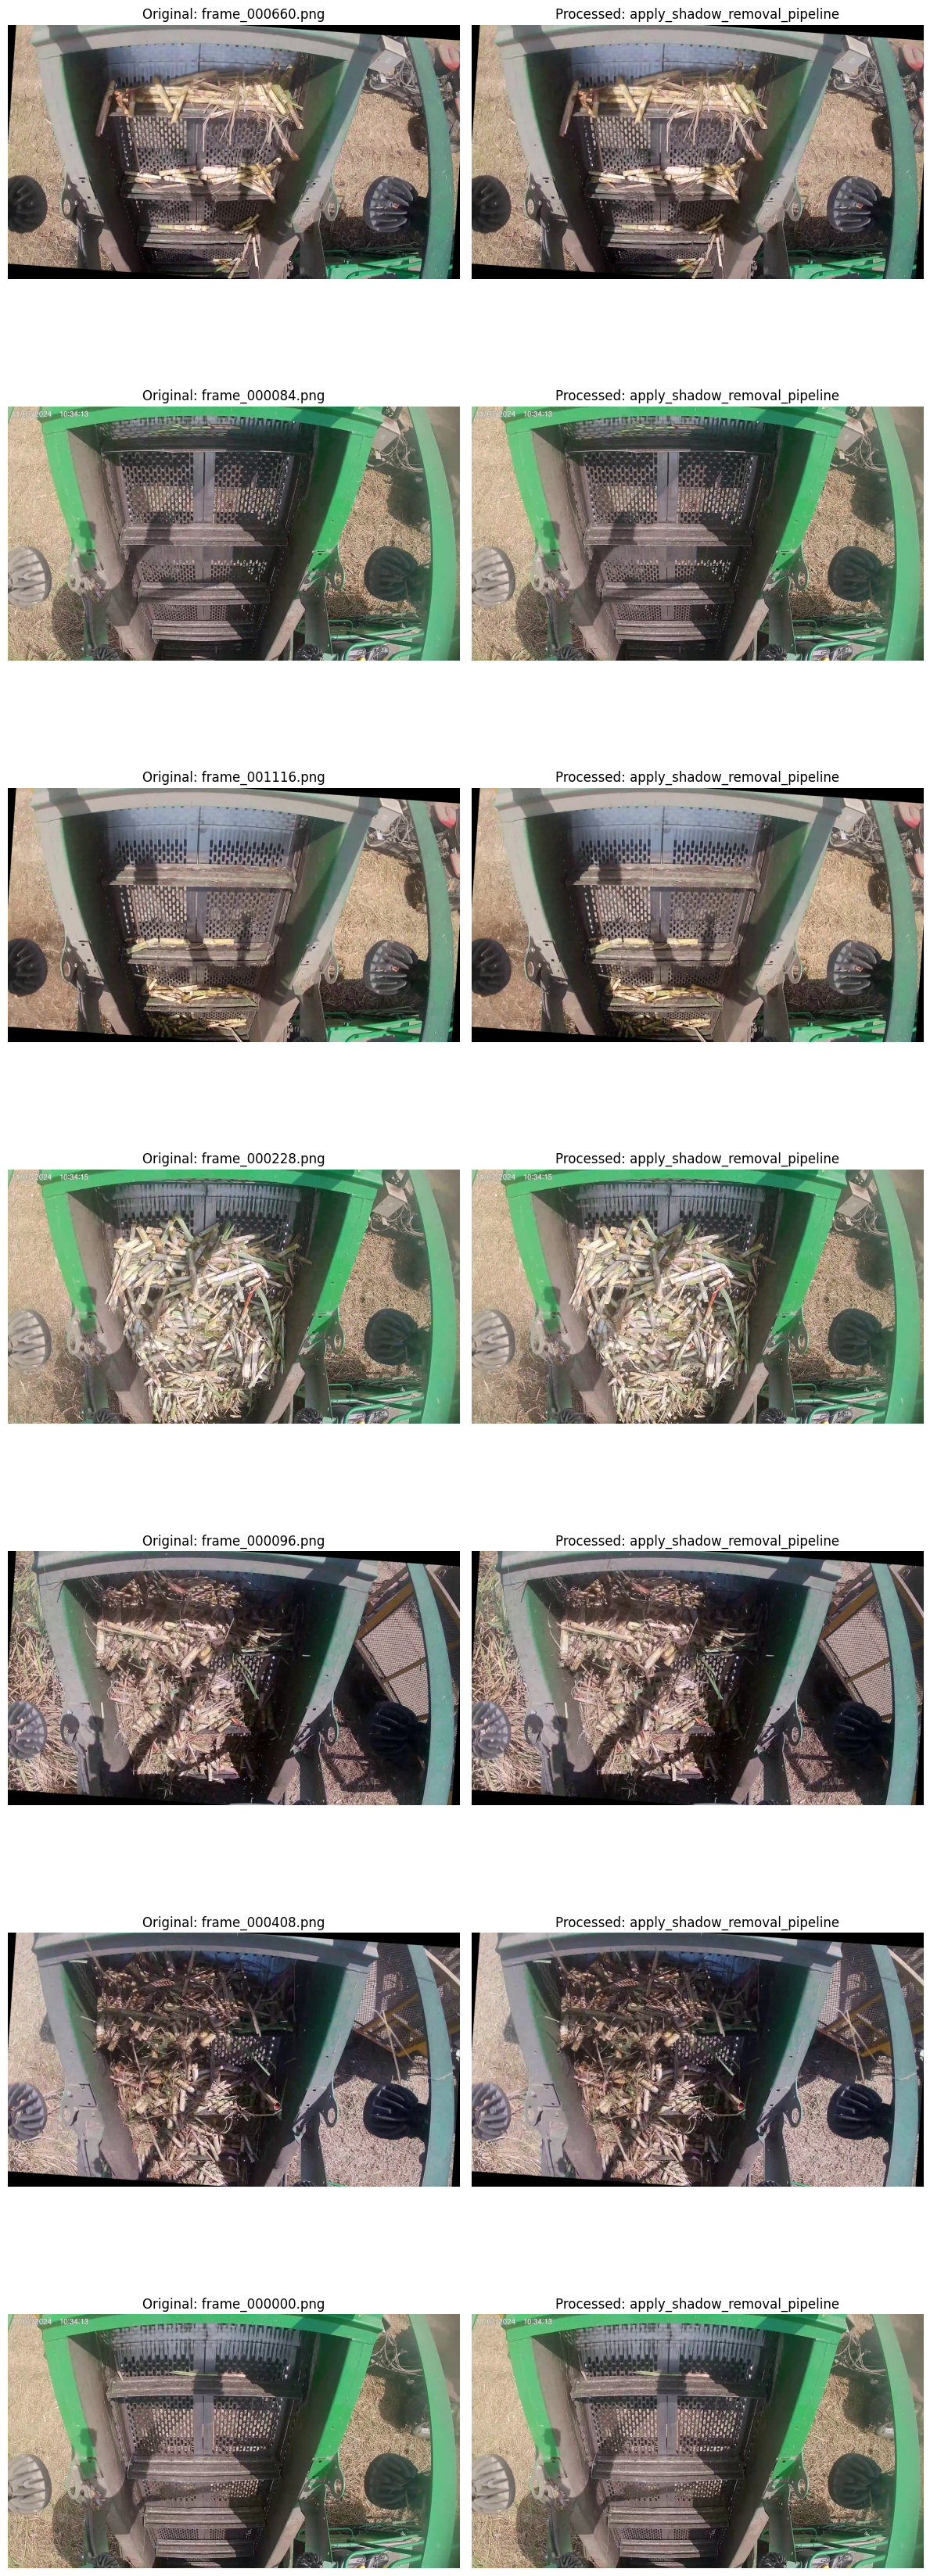

In [14]:
display_results(
    apply_shadow_removal_pipeline,
    images
)